# Homework 7 Template

Rixin Li & G . Besla



In [ ]:
# Make edits where instructed - look for "****", which indicates where you need to add code. 

In [24]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# **** import CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass2 import CenterOfMass

# **** import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import ComponentMass


# M33AnalyticOrbit

In [9]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, fout): # **** add inputs
        """ 
        Class to integrate the orbit of M33 forwards in time.

        Parameters
        -----------
            fout: `string`
                the filename of the output file for
                storing the integrated orbit
        """

        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2)
        
        ### **** store the output file name
        self.fout = fout
        
        ### get the current pos/vel of M33 
        # **** create an instance of the  CenterOfMass class for M33
        COM_M33 = CenterOfMass('M33_000.txt', 2) 

        # **** store the position VECTOR of the M33 COM (.value to get rid of units)
        # radius decreases by 2 each iteration, same as in original CenterOfMass
        r_COM_M33 = COM_M33.COM_P(2) # leave units to make getting the velocity easier

        # **** store the velocity VECTOR of the M33 COM (.value to get rid of units)
        v_COM_M33 = COM_M33.COM_V(r_COM_M33[0], r_COM_M33[1], r_COM_M33[2])
        
        ### get the current pos/vel of M31 
        # **** create an instance of the  CenterOfMass class for M31 
        COM_M31 = CenterOfMass('M31_000.txt', 2) 

        # **** store the position VECTOR of the M31 COM (.value to get rid of units)
        r_COM_M31 = COM_M31.COM_P(2) # leave units to make getting the velocity easier

        # **** store the velocity VECTOR of the M31 COM (.value to get rid of units)
        v_COM_M31 = COM_M31.COM_V(r_COM_M31[0], r_COM_M31[1], r_COM_M31[2])      
        
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # **** create two VECTORs self.r0 and self.v0 and have them be the
        # relative position and velocity VECTORS of M33
        self.r0 = r_COM_M33 - r_COM_M31
        self.v0 = v_COM_M33 - v_COM_M31
        
        ### get the mass of each component in M31 
        ### disk
        # **** self.rdisk in kpc
        self.rdisk = 5*u.kpc

        # **** self.Mdisk from HW3. Remember to *1e12 to get the right units
        self.Mdisk = 0.120e12*u.Msun

        ### bulge
        # **** self.rbulge in kpc
        self.rbulge = 1*u.kpc

        # **** self.Mbulge from HW3. Remember to *1e12 to get the right units
        self.Mbulge = 0.019e12*u.Msun

        ### halo
        # **** self.rhalo = Hernquist scale length in kpc from HW5
        self.rhalo = 62.2*u.kpc

        # **** self.Mhalo from HW3. Remember to *1e12 to get the right units
        self.Mhalo = 1.921e12*u.Msun
    
    
    def HernquistAccel(self, M, r_a, r): # it is easiest if you take as an input the position VECTOR 
        """
        Calculates the gravitational acceleration vector induced
        by a Hernquist profile.

        Parameters
        -----------
            M: `astropy quantity`
                total halo or bulge mass (M_sun)
            r_a: `astropy quantity`
                scale length of the Hernquist profile (kpc)
            r: `numpy array of astropy quantities`
                relative position vector of M33 to M31 (kpc)
        
        Returns
        --------
            Hern: `numpy array of astropy quantities`
                acceleration vector due to the Hernquist
                profile (kpc/Gyr^2)
        """
        
        ### **** Store the magnitude of the position vector
        rmag = np.sqrt(r[0]**2 + r[1]**2 + r[2]**2)
        
        ### *** Store the Acceleration
        num = -self.G*M # numerator
        denom = rmag*(r_a + rmag)**2 # denominator
        Hern = (num/denom)*r #follow the formula in the HW instructions
        # NOTE: we want an acceleration VECTOR so you need to make sure that in the Hernquist equation you 
        # use  -G*M/(rmag *(ra + rmag)**2) * r --> where the last r is a VECTOR 
        
        return Hern
    
    
    
    def MiyamotoNagaiAccel(self, M, r_d, r):# it is easiest if you take as an input a position VECTOR  r 
        """
        Calculates the gravitational acceleration vector induced
        by a Miyamoto-Nagai profile.

        Parameters
        -----------
            M: `astropy quantity`
                total disk mass (M_sun)
            r_d: `astropy quantity`
                disk radius (kpc)
            r: `numpy array of astropy quantities`
                relative position vector of M33 to M31 (kpc)

        Returns
        -------
            a: `numpy array of astropy quantities`
                acceleration vector due to the
                Miyamoto-Nagai profile (kpc/Gyr^2)
        """

        
        ### Acceleration **** follow the formula in the HW instructions
        # AGAIN note that we want a VECTOR to be returned  (see Hernquist instructions)
        # this can be tricky given that the z component is different than in the x or y directions. 
        # we can deal with this by multiplying the whole thing by an extra array that accounts for the 
        # differences in the z direction:
        #  multiply the whle thing by :   np.array([1,1,ZSTUFF]) 
        # where ZSTUFF are the terms associated with the z direction
        
        # defining variables for convenience
        R = np.sqrt(r[0]**2 + r[1]**2)
        z_d = r_d/5.0
        B = r_d + np.sqrt(r[2]**2 + z_d**2)

        # scalar factor
        num = -self.G*M # scalar factor numerator
        denom = (R**2 + B**2)**1.5 # scalar factor denominator
        fac = num/denom

        # array to make including the extra factor for z easier
        zterm = B / np.sqrt(r[2]**2 + z_d**2)
        zarr = np.array([1, 1, zterm])

        # acceleration
        a = fac*r*zarr

        return a
        # the np.array allows for a different value for the z component of the acceleration
     
    
    def M31Accel(self, r): # input should include the position vector, r
        """
        Sums all acceleration vectors from each galaxy component.

        Paramaters
        ----------
            r: `numpy array of astropy quantities`
                relative position vector of M33 to M31 (kpc)
        
        Returns
        -------
            a_total: `numpy array of astropy quantities`
                total acceleration vector due to all
                galaxy components (kpc/Gyr^2)
        """

        ### Call the previous functions for the halo, bulge and disk
        # **** these functions will take as inputs variable we defined in the initialization of the class like 
        # self.rdisk etc. 

        # acceleration due to halo
        a_halo = self.HernquistAccel(self.Mhalo, self.rhalo, r)

        # bulge
        a_bulge = self.HernquistAccel(self.Mbulge, self.rbulge, r)

        # and disk
        a_disk = self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r)

        # return the SUM of the output of the acceleration functions - this will return a VECTOR
        a_total = a_halo + a_bulge + a_disk

        #print(a_halo, a_bulge, a_disk, a_total)

        return a_total
    

    
    def LeapFrog(self, dt, r, v): # take as input r and v, which are VECTORS. Assume it is ONE vector at a time
        """
        Uses a variant of the Leap Frog integration method to
        integrate the orbit of M33 one step fowards 
        (or backwards) in time.

        Parameters
        ----------
            dt: `astropy quantity`
                time interval for integration (Gyr)
            r: `numpy array of astropy quantities`
                starting position vector of M33 
                relative to M31 (kpc)
            v: `numpy array of astropy quantities`
                starting velocity vector of M33 
                relative to M31 (km/s)
        
        Returns
        -------
            rnew: `numpy array of astropy quantities`
                relative M33 position vector advanced
                one timestep forwards (kpc)
            vnew: `numpy array of astropy quantities`
                relative M33 velocity vector advanced
                one timestep forwards (km/s)
        """
        
        # predict the position at the next half timestep
        rhalf = (r + v*(dt/2)).to(u.kpc)
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        a = self.M31Accel(rhalf)
        vnew = (v + a*dt).to(u.km/u.s)
        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        rnew = (rhalf + vnew*(dt/2)).to(u.kpc)

        #print(rnew, vnew, a)
        
        return rnew, vnew # **** return the new position and velcoity vectors
    
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        """
        Uses the LeapFrog integrator to compute the future
        orbit of M33.

        Parameters
        ----------
            t0: `astropy quantity`
                starting time (Gyr)
            dt: `astropy quantity`
                time interval for integration (Gyr)
            r: `numpy array of astropy quantities`
                starting position vector of M33 
                relative to M31 (kpc)
            v: `numpy array of astropy quantities`
                starting velocity vector of M33 
                relative to M31 (kpc/Gyr)
        """

        # initialize the time to the input starting time
        t = t0
        
        # initialize an empty array of size :  rows int(tmax/dt)+2  , columns 7
        nrows = int(tmax/dt)+2
        orbit = np.zeros((nrows,7))
        
        # initialize the first row of the orbit
        orbit[0] = t0.value, *tuple(self.r0.value), *tuple(self.v0.value)
        # this above is equivalent to 
        # orbit[0] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]
        
        
        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1
        
        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while (t <= tmax):  # as long as t has not exceeded the maximal time 
            
            # **** advance the time by one timestep, dt
            t += dt
           
            # **** store the new time in the first column of the ith row
            orbit[i,0] = t.value
            
            # ***** advance the position and velocity using the LeapFrog scheme
            # remember that LeapFrog returns a position vector and a velocity vector  
            # as an example, if a function returns three vectors you would call the function and store 
            # the variable like:     a,b,c = function(input)
            r = np.array(orbit[i-1,1:4])*u.kpc # previous position
            v = np.array(orbit[i-1,4:7])*u.km/u.s # and velocity
            rnew, vnew = self.LeapFrog(dt, r, v)
         
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            # TIP:  if you want columns 5-7 of the Nth row of an array called A, you would write : 
            # A[n, 5:8] 
            # where the syntax is row n, start at column 5 and end BEFORE column 8
            orbit[i,1:4] = rnew.value # store position
            orbit[i,4:7] = vnew.value # and velocity
            
            # **** update counter i , where i is keeping track of the number of rows (i.e. the number of time steps)
            i += 1
        
        
        # write the data to a file
        np.savetxt(self.fout, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        
        # there is no return function

# Q1

In [10]:
# create M33AnalyticOrbit instance
orbitintegrator = M33AnalyticOrbit('M33_analytic_orbit.txt')

In [11]:
# define time interval and timestep
t0 = 0*u.Gyr # start
tmax = 10*u.Gyr # end
dt = 0.1*u.Gyr # step

In [12]:
# ladies and gentlemen, welcome to today's episode of
# INTEGRATE! THAT!! ORBIT!!!
orbitintegrator.OrbitIntegration(t0, dt, tmax)

In [ ]:
# import orbit data files & calculate radius

# analytic integration
orbit_hw7 = ascii.read('M33_analytic_orbit.txt')
r_hw7 = np.sqrt(orbit_hw7['x']**2 + orbit_hw7['y']**2 + orbit_hw7['z']**2) # position
v_hw7 = np.sqrt(orbit_hw7['vx']**2 + orbit_hw7['vy']**2 + orbit_hw7['vz']**2) # velocity

In [25]:
# solution from HW 6
# import orbits of M33 and M31
# headers:  t, x, y, z, vx, vy, vz
orbit_M33_hw6 = np.genfromtxt('Orbit_M33.txt')
orbit_M31_hw6 = np.genfromtxt('Orbit_M31.txt')

In [ ]:
# from HW 6 to make my life easier
def vector_diff_mag(vec1, vec2):
    '''
    Computes the magnitude of the difference between
    two vectors.

    Parameters:
        vec1, vec2: `ndarrays`
            vectors of equal dimensions whose 
            difference is to be found.
    Returns:
        vd_mag: `ndarray`
            the magnitude of the difference 
            between vec1 and vec2.
    '''
    # calculate the difference of the two vectors
    vec_diff = vec1 - vec2 
    # get the magnitude of the difference
    vd_mag = np.sqrt(np.sum(vec_diff**2, axis=1))

    return vd_mag

In [29]:
# calculate relative position of M33 to M31 from HW6
r_hw6 = vector_diff_mag(orbit_M31_hw6[:,1:4], orbit_M33_hw6[:,1:4])*u.kpc
# and relative velocity
v_hw6 = vector_diff_mag(orbit_M31_hw6[:,4:7], orbit_M33_hw6[:,4:7])*u.km/u.s

Text(0.5, 0.98, 'Predicted M33 Orbit')

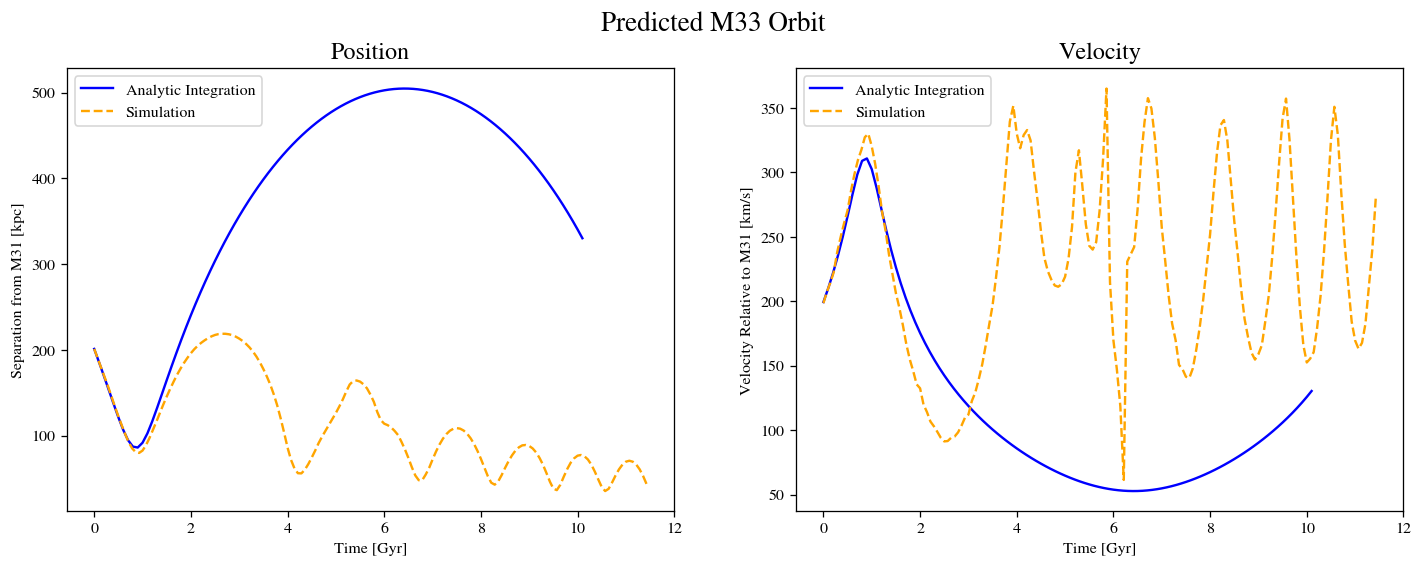

In [36]:
# plot time! :D

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['figure.dpi'] = 115 # increase the resolution slightly

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

# position vs. time

# M33 orbit from this homework
ax1.plot(orbit_hw7['t'], r_hw7, c='b', label='Analytic Integration')
# M31-M33 orbit
ax1.plot(orbit_M33_hw6[:,0], r_hw6, c='orange', label='Simulation',
        linestyle='--')

ax1.set_xlabel('Time [Gyr]')
ax1.set_ylabel('Separation from M31 [kpc]')
ax1.legend()
ax1.set_title('Position', fontsize=15)

# position vs. time

# M33 orbit from this homework
ax2.plot(orbit_hw7['t'], v_hw7, c='b', label='Analytic Integration')
# M31-M33 orbit
ax2.plot(orbit_M33_hw6[:,0], v_hw6, c='orange', label='Simulation',
        linestyle='--')

ax2.set_xlabel('Time [Gyr]')
ax2.set_ylabel('Velocity Relative to M31 [km/s]')
ax2.legend()
ax2.set_title('Velocity', fontsize=15)

fig.suptitle('Predicted M33 Orbit', fontsize=17)

# Q2
In both plots, M33 first makes a close approach to M31, coming within ~ 100 kpc of its center of mass. Both plots also seem to follow the same pattern of M33 repeatedly making a close approach to M31 before swinging away again, slowly getting closer to M31 (although the analytically integrated orbit has yet to complete a full "orbit," so this is somewhat of a conjecture.) The range of velocities attained in both orbits is also roughly the same.

However, the analytically integrated orbit has a much lower frequency than the simulated one &mdash; again, it has only made one full "orbit" in the same time that the latter had made ~ 4 &mdash; and it also goes out to much larger distances from M31, decaying far more slowly overall. The analytically integrated orbit also tends towards lower velocities, since it goes out to much further radii.

# Q3
There are a few missing things that could be hindering the agreement between the analytic integration and the simulation. Likely the most important is the fact that M33 is treated at a point particle with its entire mass at its COM position instead of an extended system of particles; similarly, M31's components are approximated by analytic profiles instead of being treated as particles. Slightly less important is the fact that the integration doesn't account for the gravitational influence of M33 on M31; given that M33 has ~10% of the mass of M31, its tug on M31 likely doesn't affect the position of M31 a large amount, but it would still help draw the two galaxies closer together.

# Q4
One way you can include the effects of the Milky Way is to calculate its COM position and velocity relative to M31 and integrate its orbit forward based on the acceleration due to M31 like with M33, but to then account for the effects of the Milky Way on M33 the same way as M31, using the Hernquist and Miyamoto-Nagai profiles (replacing $r$ with $r-r_{COM,MW}$ where relevant). This would still have the issues mentioned in Q3, but it's a start at least.